In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import os
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as k

Using TensorFlow backend.


In [2]:
labels = os.listdir('../input/kermany2018/OCT2017 /train/')
print(labels)
train_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              zoom_range=0.15,
                                   validation_split=0.2)

['DRUSEN', 'DME', 'CNV', 'NORMAL']


In [3]:
IMG_SIZE = 224
batch_size = 16
train_data_dir = '../input/kermany2018/OCT2017 /train'
validation_data_dir = '../input/kermany2018/OCT2017 /val'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=16,
    subset='training',
    class_mode='categorical')
valid_X, valid_Y = next(train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=4000,
    subset='validation',
    class_mode='categorical'))

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


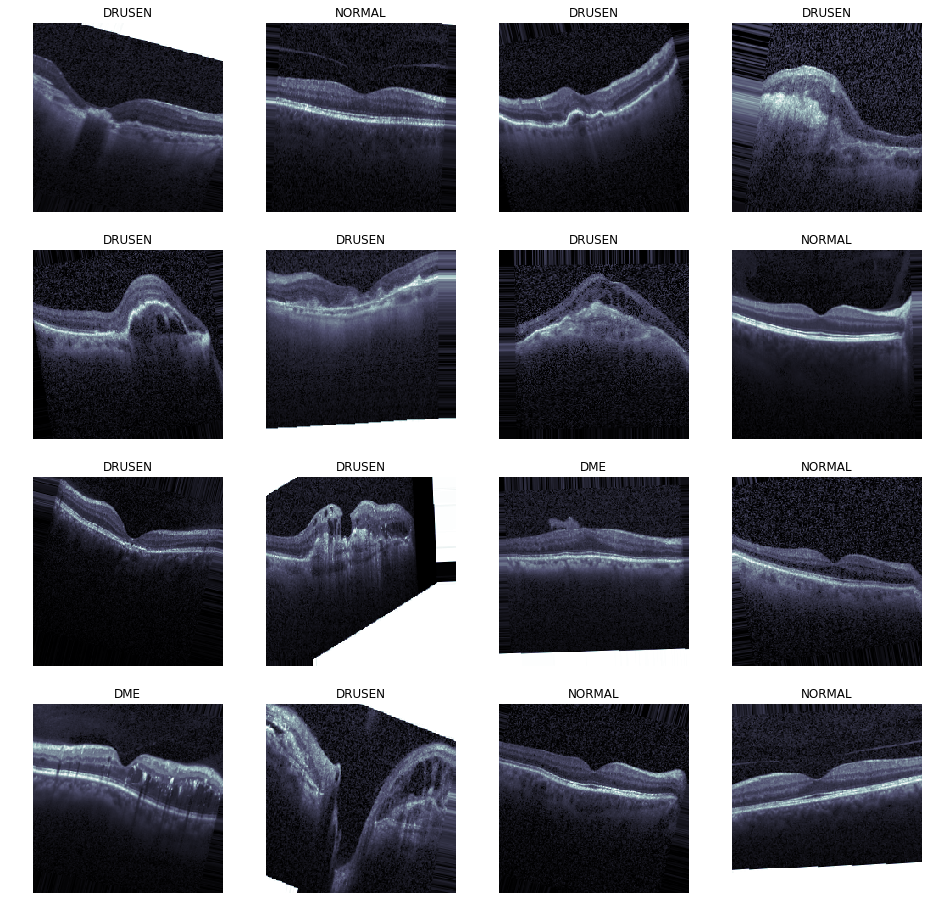

In [4]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [5]:
# defining densenet model
def conv_layer():
    model=Sequential()
    model.add(Conv2D(64,(5,5),activation='relu',input_shape=(224,224,3),kernel_initializer='he_normal'))
    model.add(Conv2D(64,(5,5),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(5,5),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,5,activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16,(5,5),activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
    model.add(Dense(32,activation='relu',kernel_initializer='he_normal'))
    model.add(Dense(4,activation='softmax'))
    return model

In [6]:
# compiling model
model = conv_layer()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])

In [7]:
# creating checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [8]:
# training the model
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=100,
                                  validation_data = (valid_X,valid_Y), 
                                  epochs = 10,
                                  callbacks=callbacks_list)

Epoch 1/10
100/100 [==============================] - 1118s 11s/step - loss: 1.2731 - accuracy: 0.4481 - val_loss: 1.2952 - val_accuracy: 0.3792

Epoch 00001: val_accuracy improved from -inf to 0.37925, saving model to weights.best.hdf5
Epoch 2/10
100/100 [==============================] - 1114s 11s/step - loss: 1.1435 - accuracy: 0.5650 - val_loss: 0.9407 - val_accuracy: 0.6752

Epoch 00002: val_accuracy improved from 0.37925 to 0.67525, saving model to weights.best.hdf5
Epoch 3/10
100/100 [==============================] - 1113s 11s/step - loss: 0.9663 - accuracy: 0.6519 - val_loss: 0.8192 - val_accuracy: 0.7165

Epoch 00003: val_accuracy improved from 0.67525 to 0.71650, saving model to weights.best.hdf5
Epoch 4/10
100/100 [==============================] - 1115s 11s/step - loss: 0.7642 - accuracy: 0.7387 - val_loss: 0.7515 - val_accuracy: 0.7327

Epoch 00004: val_accuracy improved from 0.71650 to 0.73275, saving model to weights.best.hdf5
Epoch 5/10
100/100 [=======================

In [9]:
# loading the model with best weight

model = conv_layer()
model.load_weights(filepath)

In [10]:
# creating test data
test_X, test_Y = next(train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=8000,
    subset='validation',
    class_mode='categorical'))

Found 16696 images belonging to 4 classes.


In [11]:
# predicting y value
y_pred = model.predict(test_X)

In [12]:
pred_class = []
for i in range(len(y_pred)):
    pred_class.append(np.argmax(y_pred[i]))

In [13]:
actual_class = []
for i in range(len(test_Y)):
    actual_class.append(np.argmax(test_Y[i]))

In [14]:
#  accuracy score
from sklearn.metrics import accuracy_score
print('accuracy = ',accuracy_score(pred_class,actual_class))

accuracy =  0.773


In [15]:
# defining confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,3]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


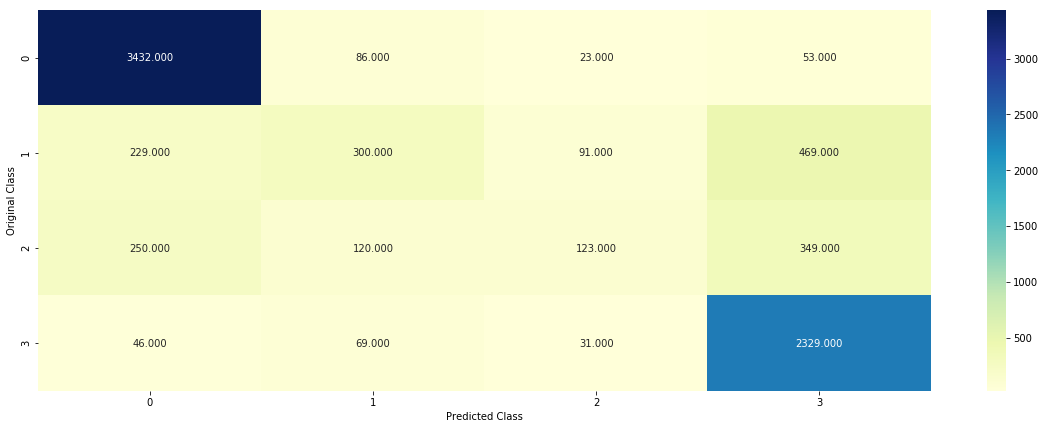

-------------------- Precision matrix (Columm Sum=1) --------------------


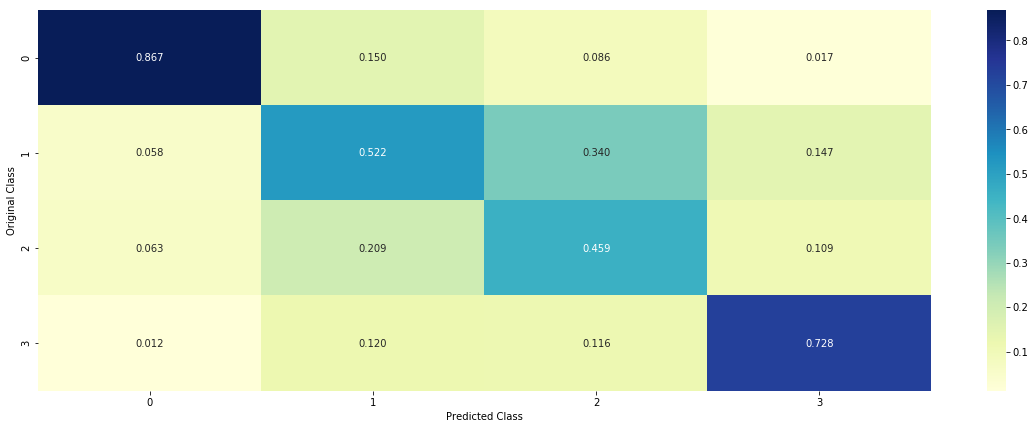

-------------------- Recall matrix (Row sum=1) --------------------


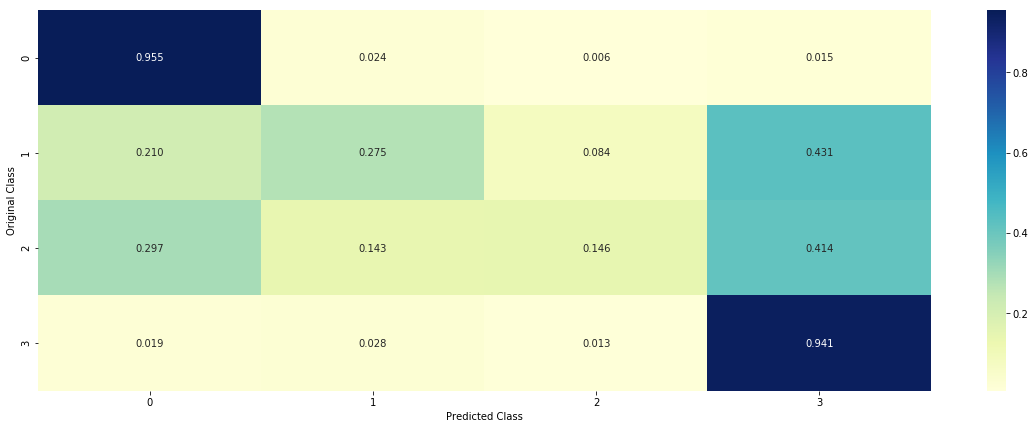

In [16]:
plot_confusion_matrix(actual_class,pred_class)